# Project: Generalized Sliced Distances for Probability Distributions
_Mathis Hardion_

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import seaborn as sns
import pandas as pd

sns.set_theme(style='ticks', rc={'axes.grid':False, "axes.facecolor":'white', 'xtick.bottom':True, 'ytick.left':True,
                  'grid.color':'.15'})

# Set rng seed
rng = np.random.default_rng(seed=0)

In [2]:
# Visualization
def plot_flow(X, s=5, title=""):
    fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios":[1,0.05]})
    axes = axes.ravel()
    data = np.hstack((X.reshape(-1,2), np.repeat(np.arange(X.shape[0]), X.shape[1])[:,None]))
    df = pd.DataFrame(data=data, columns=['x', 'y', 'iter'])
    ax = sns.scatterplot(data=df, x='x', y='y', hue='iter', s=s, edgecolor='none', palette='plasma',
                         legend=False, ax=axes[0] )
    norm = plt.Normalize(0, X.shape[0])
    sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
    sm.set_array([])
    ax.figure.colorbar(sm, cax=axes[1], label="iteration")
    fig.suptitle(title)
    return ax

## Different behaviors

In [3]:
# Computation of GSPMs

def kernel(x, y, f, theta_sampler, K, sigma):
    theta = theta_sampler(K)
    return stats.norm.pdf(f(theta, x)[:,:,None] - f(theta, y)[:,None,:], scale=sigma).mean(axis=0)

def kernel_intexp(x, y, f, theta_sampler, K, sigma, T=100):
    theta = theta_sampler(K)
    fx, fy = f(theta, x), f(theta, y)
    max_fxfy = np.concatenate((fx[:,:,None], fy[:,:,None]), axis=2).max(axis=2)
    return np.exp((fx + fy - 2*max_fxfy)/sigma)

def gspm_mmd(sampler1, N, sampler2, M, theta_sampler, K, f, sigma, ker=kernel):
    x = sampler1(N)
    y = sampler2(M)
    return np.sqrt((ker(x, x, f, theta_sampler, K, sigma).mean()
                    + ker(y, y, f, theta_sampler, K, sigma).mean()
                    - 2*ker(x, y, f, theta_sampler, K, sigma).mean()))

In [4]:
# Slices
def f_linear(theta, x):
    return theta @ x.T
def df_linear(theta, x):
    return np.repeat(theta[:,None], x.shape[0], axis=1)
def theta_sampler_linear(K):
    t = 2*np.pi*rng.random(K)
    return np.vstack((np.cos(t), np.sin(t))).T

def f_circular(theta, x):
    return np.sqrt((x**2).sum(axis=1)[None,:] + (theta**2).sum(axis=1)[:,None] - 2*theta @ x.T)
def df_circular(theta, x):
    d = x[None,:,:] - theta[:,None,:]
    d /= np.sqrt((d*d).sum(axis=-1))[...,None]
    return d
def theta_sampler_circular(K, R=1):
    t = rng.standard_normal((K, 2))
    t /= np.sqrt((t*t).sum(axis=1))[:,None]
    return R*t

In [13]:
K = 50
N = 200
M = 200
mux, muy = np.mgrid[-10:10:1,-10:10:1]
sigmas = [1, .5, .1, .01]
mu = np.concatenate((mux[:,:,None], muy[:,:,None]), axis=-1)

def gspm_mmd_matrix(f, theta_sampler, sigma, ker=kernel):
    D = np.zeros(mux.shape)
    sampler1 = lambda N: rng.standard_normal((N,2))
    for i in range(mu.shape[0]):
        for j in range(mu.shape[1]):
            sampler2 = lambda M: mu[i,j,:]+rng.standard_normal((M,2))
            D[i, j] = gspm_mmd(sampler1, N, sampler2, M, theta_sampler, K, f, sigma, ker)
    return D

D_W2 = np.sqrt((mu**2).sum(axis=-1))
D_gspm_mmd = [[], []]
for sig in sigmas:
    D_gspm_mmd[0].append(gspm_mmd_matrix(f_linear, theta_sampler_linear, sig,))
    D_gspm_mmd[1].append(gspm_mmd_matrix(f_circular, theta_sampler_circular, sig))
D_gspm_mmd = np.array(D_gspm_mmd)

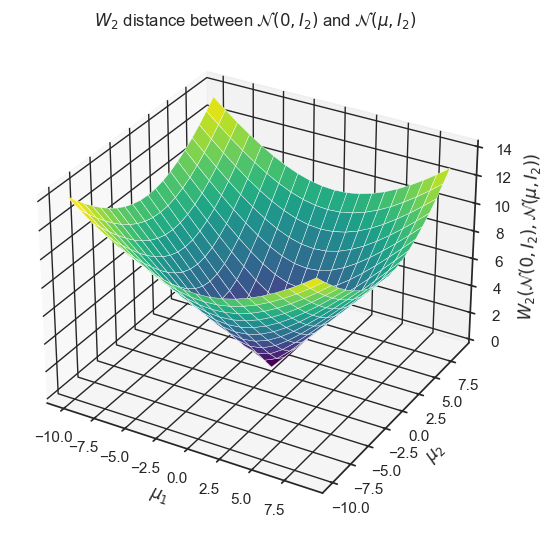

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8,8), subplot_kw={"projection": "3d"},
                      width_ratios=[1, 0.001])
axes[1].axis("off")
ax = axes[0]
ax.plot_surface(mux, muy, D_W2, lw=0.3, cmap='viridis')
ax.set(xlabel=r"$\mu_1$", ylabel=r"$\mu_2$", zlabel='$W_2(\mathcal{N}(0, I_2), \mathcal{N}(\mu, I_2))$',
       title="$W_2$ distance between $\mathcal{N}(0, I_2)$ and $\mathcal{N}(\mu, I_2)$")
fig.suptitle("")
plt.subplots_adjust(right=0.8)
plt.savefig("W2.png")

In [8]:
D_gspm_mmd[0, 0][10, 10]

0.05138954190936803

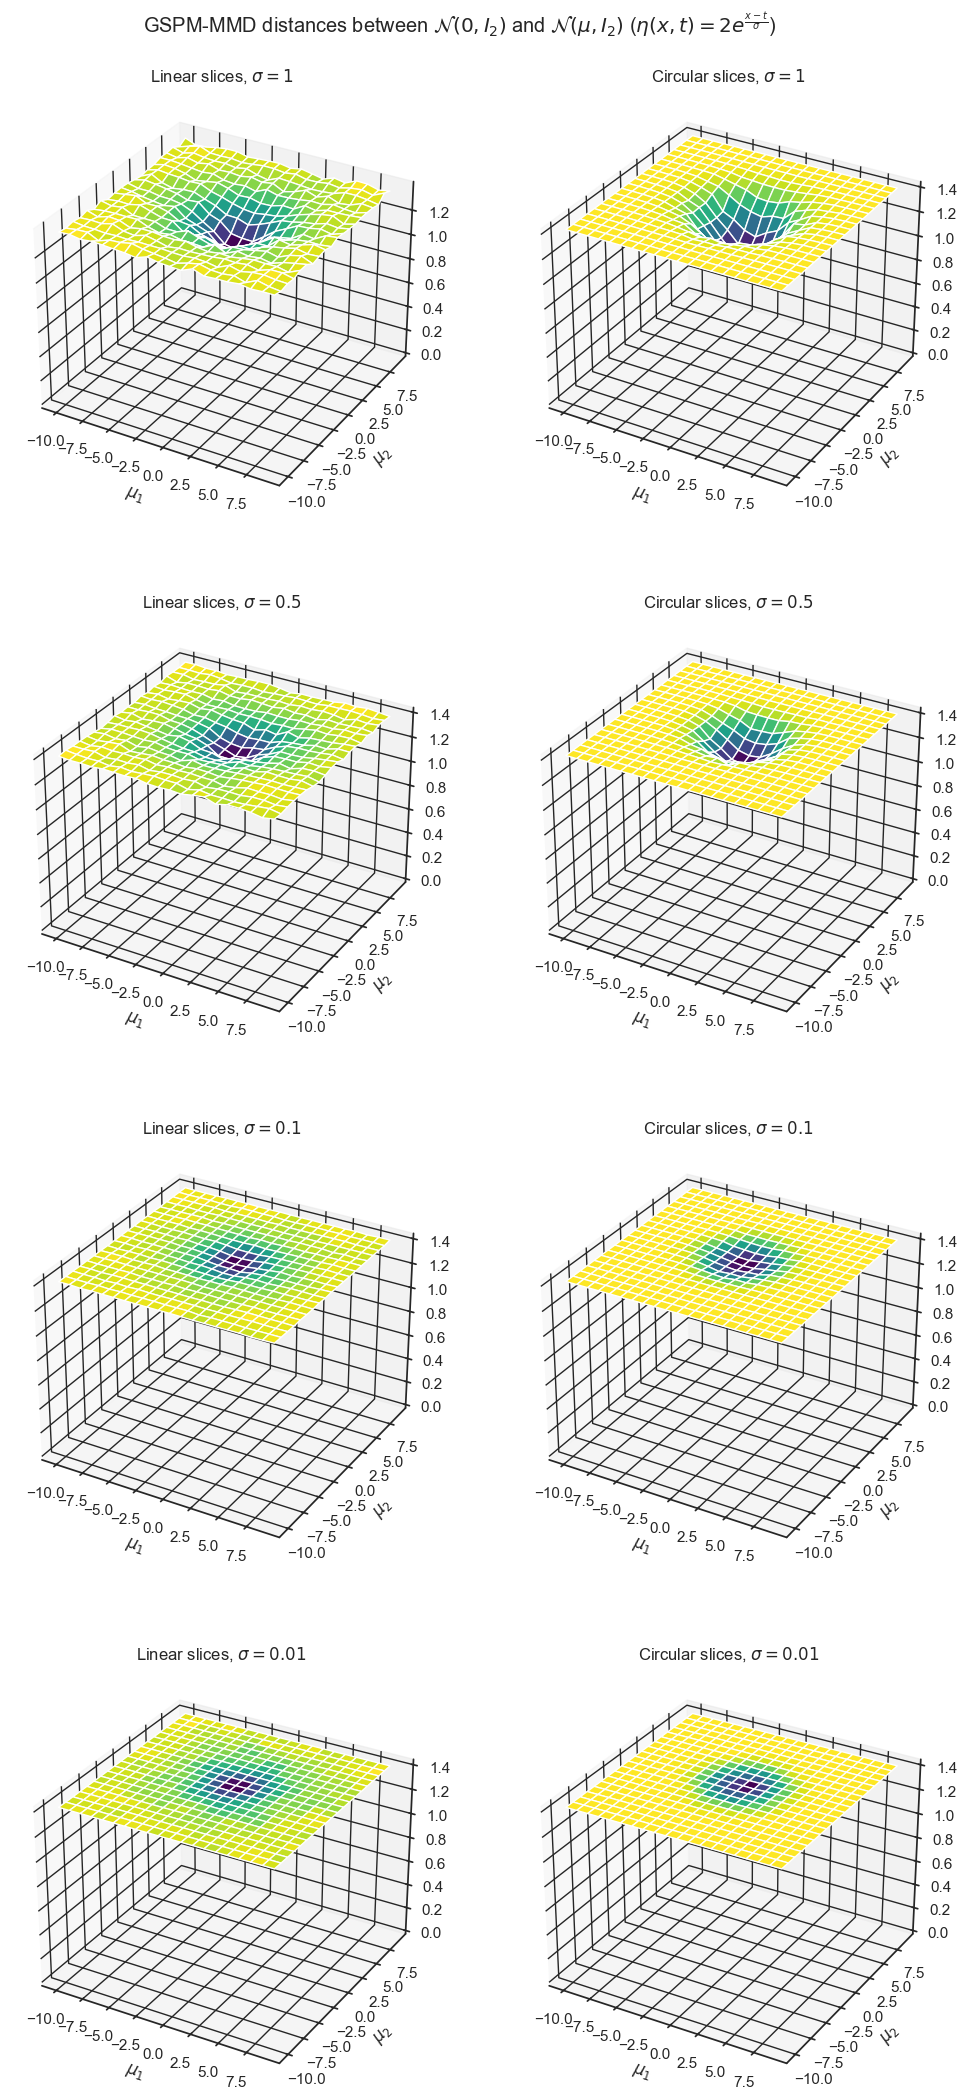

In [15]:
nrows = len(sigmas)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows), subplot_kw={"projection": "3d"})
for r in range(nrows):
    axes[r, 0].plot_surface(mux, muy, D_gspm_mmd[0, r],cmap='viridis')
    axes[r, 0].set(title=rf"Linear slices, $\sigma={sigmas[r]}$", zlim=(0, D_gspm_mmd[0, r].max()), xlabel=r"$\mu_1$", ylabel=r"$\mu_2$")
    axes[r, 1].plot_surface(mux, muy, D_gspm_mmd[1, r], cmap='viridis')
    axes[r, 1].set(title=rf"Circular slices, $\sigma={sigmas[r]}$", zlim=(0, D_gspm_mmd[1, r].max()), xlabel=r"$\mu_1$", ylabel=r"$\mu_2$")
fig.suptitle(r'GSPM-MMD distances between $\mathcal{N}(0, I_2)$ and $\mathcal{N}(\mu, I_2)$ ($\eta(x,t) = 2e^{\frac{x-t}{\sigma}}$)')
plt.subplots_adjust(top=0.95)
# plt.savefig("GSPM-MMD.png")

In [18]:
K = 50
N = 200
M = 200
mux, muy = np.mgrid[-10:10:1,-10:10:1]
sigmas = [1, .1, .01]
mu = np.concatenate((mux[:,:,None], muy[:,:,None]), axis=-1)

def gspm_mmd_matrix(f, theta_sampler, sigma, ker=kernel):
    D = np.zeros(mux.shape)
    sampler1 = lambda N: rng.standard_cauchy((N,2))
    for i in range(mu.shape[0]):
        for j in range(mu.shape[1]):
            sampler2 = lambda M: mu[i,j,:]+rng.standard_cauchy((M,2))
            D[i, j] = gspm_mmd(sampler1, N, sampler2, M, theta_sampler, K, f, sigma, ker)
    return D

D_W2 = np.sqrt((mu**2).sum(axis=-1))
D_gspm_mmd = [[], []]
for sig in sigmas:
    D_gspm_mmd[0].append(gspm_mmd_matrix(f_linear, theta_sampler_linear, sig,))
    D_gspm_mmd[1].append(gspm_mmd_matrix(f_circular, theta_sampler_circular, sig))
D_gspm_mmd = np.array(D_gspm_mmd)

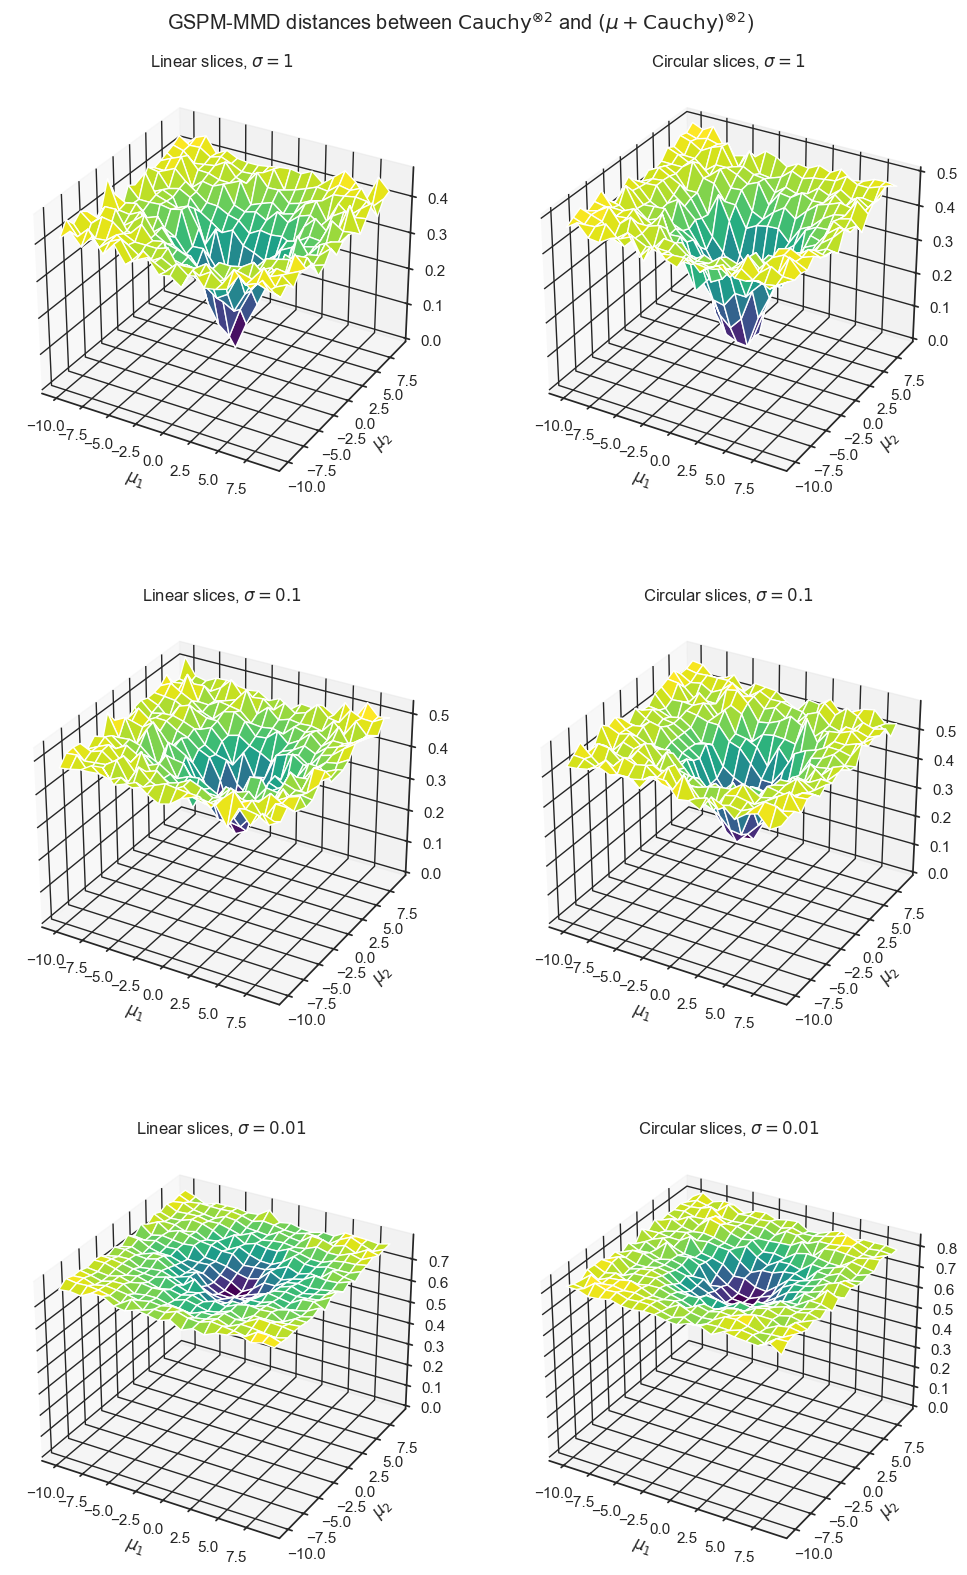

In [22]:
nrows = len(sigmas)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows), subplot_kw={"projection": "3d"})
for r in range(nrows):
    axes[r, 0].plot_surface(mux, muy, D_gspm_mmd[0, r],cmap='viridis')
    axes[r, 0].set(title=rf"Linear slices, $\sigma={sigmas[r]}$", zlim=(0, D_gspm_mmd[0, r].max()), xlabel=r"$\mu_1$", ylabel=r"$\mu_2$")
    axes[r, 1].plot_surface(mux, muy, D_gspm_mmd[1, r], cmap='viridis')
    axes[r, 1].set(title=rf"Circular slices, $\sigma={sigmas[r]}$", zlim=(0, D_gspm_mmd[1, r].max()), xlabel=r"$\mu_1$", ylabel=r"$\mu_2$")
fig.suptitle(r'GSPM-MMD distances between $\text{Cauchy}^{\otimes 2}$ and $(\mu+\text{Cauchy})^{\otimes 2}$)')
plt.subplots_adjust(top=0.95)
plt.savefig("GSPM-MMD-cauchy.png")

## Gradient flows

In [5]:
def gradk(theta, x, y, f, df, sigma):
    """Gradient of the kernel corresponding to slices given by f(theta, .) of derivative df(theta, .)
    """
    delta = f(theta, x)[:,:,None] - f(theta, y)[:,None,:]
    E = delta*stats.norm.pdf(delta, scale=sigma)/(sigma**2)
    return (E[...,None]*df(theta, y)[:,None,:,:]).mean(axis=0)

In [6]:
def GSPM_MMD_gradient_flow(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma):
    x = initial_sampler(N)
    X = [x.copy()]
    for n in range(n_iter):
        y = target_sampler(M)
        x_noisy = x + beta(n)*rng.standard_normal(x.shape)
        theta = theta_sampler(K)
        v = gradk(theta, y, x_noisy, f, df, sigma).mean(axis=0) - gradk(theta, x, x_noisy, f, df, sigma).mean(axis=0)
        x += eta*v
        X.append(x.copy())
    return np.array(X)  

In [19]:
# Gaussian to gaussian, simple slices
f = f_linear
df = df_linear
d = 2
N = 50
def target_sampler(M):
    return 5 + rng.standard_normal((M,d))
def initial_sampler(N):
    return rng.standard_normal((N, d)) - 5
M = 50
theta_sampler = theta_sampler_linear
K = 20
n_iter = 2000
eta = .5
beta = lambda n: .1/(n+1)**2
sigma = 1

In [20]:
X = GSPM_MMD_gradient_flow(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma)

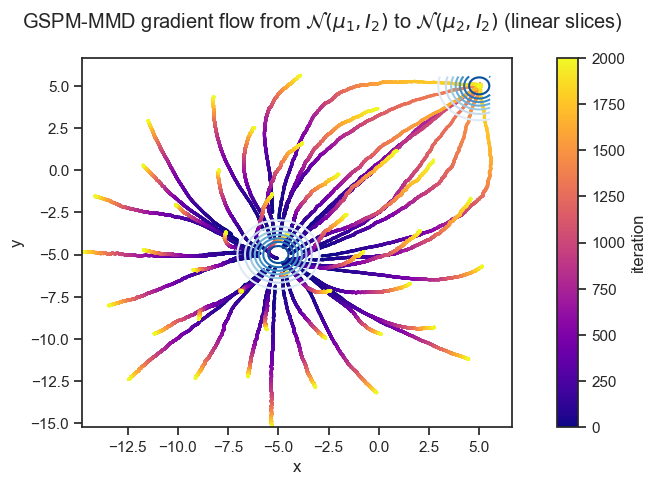

In [21]:
ax = plot_flow(X, title=r"GSPM-MMD gradient flow from $\mathcal{N}(\mu_1, I_2)$ to $\mathcal{N}(\mu_2, I_2)$ (linear slices)")
(xm, xM) = X[:,:,0].min(), X[:,:,0].max()
(ym, yM) = X[:,:,1].min(), X[:,:,1].max()
xx, yy = np.mgrid[xm:xM:.1, ym:yM:.1]
xy = np.concatenate((xx[:,:,None], yy[:,:,None]), axis=-1)
zz = stats.multivariate_normal.pdf(xy, mean=[5, 5]) + stats.multivariate_normal.pdf(xy, mean=[-5, -5])
ax.contour(xx, yy, zz, cmap='Blues')
# plt.savefig("GSPM-MMD_flow_2gauss_lin.png")

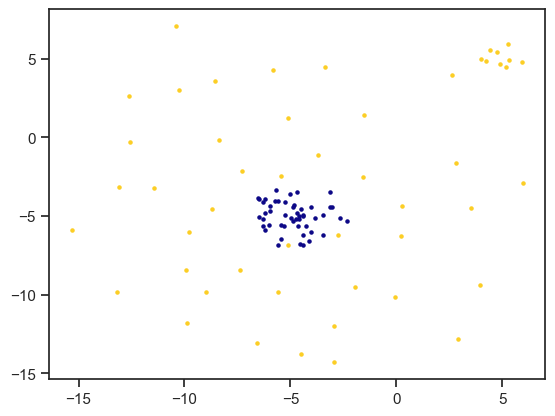

In [28]:
plt.scatter(X[0,:,0], X[0,:,1], color=mpl.colormaps['plasma'](0), marker='.', s=20)
plt.scatter(X[-1,:,0], X[-1,:,1], color=mpl.colormaps['plasma'](0.9), marker='.', s=20)

In [20]:
# Circular slices
f = f_circular
df = df_circular
def theta_sampler(K):
    t = 2*np.pi*rng.random(K)
    return 10*np.vstack((np.cos(t), np.sin(t))).T
X = GSPM_MMD_gradient_flow(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma)

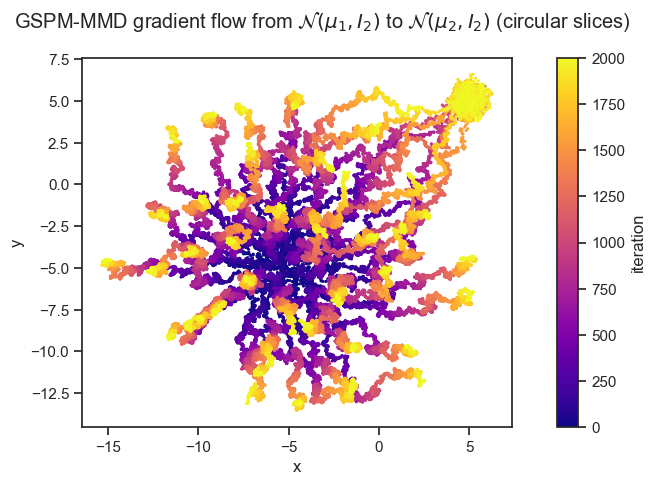

In [22]:
plot_flow(X, title=r"GSPM-MMD gradient flow from $\mathcal{N}(\mu_1, I_2)$ to $\mathcal{N}(\mu_2, I_2)$ (circular slices)")
plt.savefig("GSPM-MMD_flow_2gauss_circ.png")

In [47]:
# Small gaussian to circle, simple slices
def f(theta, x):
    return theta @ x.T
def df(theta, x):
    return np.repeat(theta[:,None,:], x.shape[0], axis=1)
d = 2
initial_sampler = lambda N: 0.01*rng.standard_normal((N, d))
N = 50
R = 10
dR = 2
def target_sampler(M):
    t = rng.random(M)*2*np.pi
    r = R + dR*rng.random(M)
    return np.vstack((r*np.cos(t), r*np.sin(t))).T
M = 50
def theta_sampler(K):
    t = rng.standard_normal((K, d))
    t /= np.sqrt((t*t).sum(axis=1))[:,None]
    return t
K = 20
n_iter = 5000
eta = .5
beta = lambda n: .1/(n+1)**2
sigma = 1

In [27]:
# target_sampler, initial_sampler = initial_sampler, target_sampler

In [48]:
X = GSPM_MMD_gradient_flow(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma)

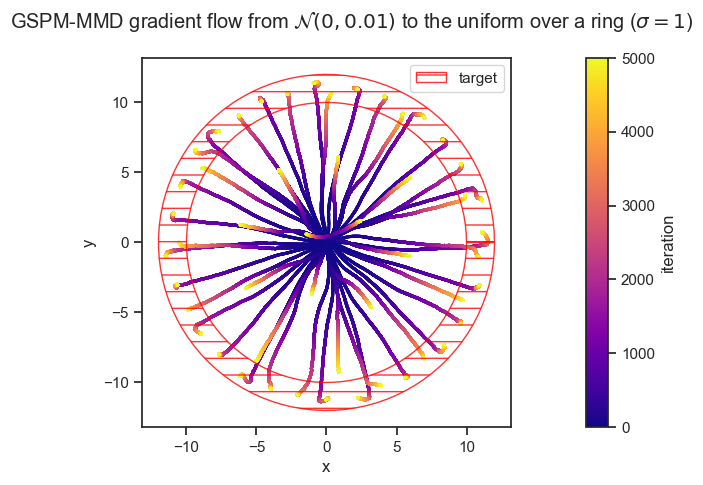

In [49]:
ax = plot_flow(X, title=r"GSPM-MMD gradient flow from $\mathcal{N}(0, 0.01)$ to the uniform over a ring ($\sigma="+str(sigma)+r"$)")
t = np.linspace(0, 2*np.pi, 100)
xx = np.concatenate((R*np.cos(t), (R+dR)*np.cos(-t)))
yy = np.concatenate((R*np.sin(t), (R+dR)*np.sin(-t)))
ax.fill(xx, yy, color='none', ec='red', hatch='-', alpha=.8)
ax.set(aspect='equal')
legend_elts = [mpl.patches.Patch(color='none', ec='red', hatch='-', alpha=.8, label='target')]
ax.legend(handles=legend_elts)
plt.savefig("GSPM-MMD_flow_gauss_to_ring_lin_sig1.png", bbox_inches='tight')

In [13]:
# Small gaussian to circle, circular slices
def f(theta, x):
    return np.sqrt((x**2).sum(axis=1)[None,:] + (theta**2).sum(axis=1)[:,None] - 2*theta @ x.T)
def df(theta, x):
    d =  x[None,:,:] - theta[:,None,:]
    d /= np.sqrt((d*d).sum(axis=-1))[...,None]
    return d
d = 2
initial_sampler = lambda N: 0.01*rng.standard_normal((N, d))
N = 50
R = 10
dR = 2
def target_sampler(M):
    t = rng.random(M)*2*np.pi
    r = R + dR*rng.random(M)
    return np.vstack((r*np.cos(t), r*np.sin(t))).T
M = 50
theta_sampler = lambda K: theta_sampler_circular(K, R=R)
K = 20
n_iter = 5000
eta = .5
beta = lambda n: .1/(n+1)
sigma = 1

In [20]:
X = GSPM_MMD_gradient_flow(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma)

[None]

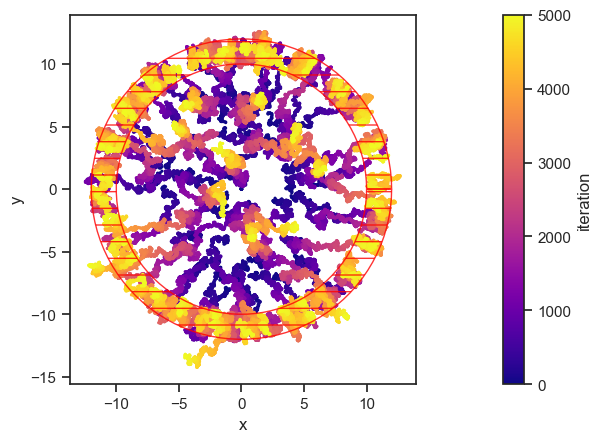

In [21]:
ax = plot_flow(X)
t = np.linspace(0, 2*np.pi, 100)
xx = np.concatenate((R*np.cos(t), (R+dR)*np.cos(-t)))
yy = np.concatenate((R*np.sin(t), (R+dR)*np.sin(-t)))
ax.fill(xx, yy, color='none', ec='red', hatch='-', alpha=.8)
ax.set(aspect='equal')

In [7]:
# gaussian to 2 gaussians, simple slices
f = f_linear
df = df_linear
d = 2
N = 50
means = np.array([[0, 0],
                  [0, 5]])
def target_sampler(M):
    k = rng.integers(0, 2, M)
    return means[k,:] + rng.standard_normal((M,d))
def initial_sampler(N):
    return means[0,:] + rng.standard_normal((N, d))
M = 50
theta_sampler = theta_sampler_linear
K = 50
n_iter = 5000
eta = .5
beta = lambda n: 1/np.sqrt(n+1)
sigma = 10

In [8]:
X = GSPM_MMD_gradient_flow(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma)

[None]

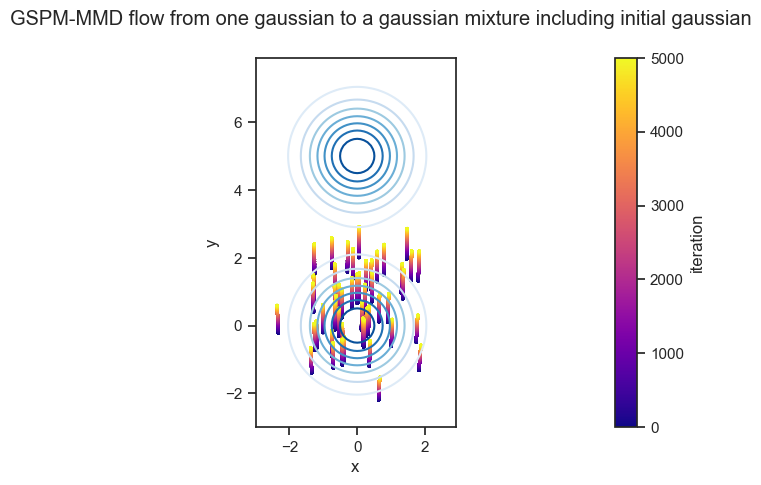

In [9]:
ax = plot_flow(X, title="GSPM-MMD flow from one gaussian to a gaussian mixture including initial gaussian")
xx, yy = np.mgrid[-3:3:.1,-3:8:.1]
zz1 = stats.multivariate_normal.pdf(np.concatenate([xx[:,:,None], yy[:,:,None]], axis=2), mean=means[0,:])
zz2 = stats.multivariate_normal.pdf(np.concatenate([xx[:,:,None], yy[:,:,None]], axis=2), mean=means[1,:])
ax.contour(xx, yy, .5*(zz1+zz2), cmap="Blues")
ax.set(aspect='equal')
# plt.savefig('flow_multimodal_more_noise.png', bbox_inches='tight')

# Extensions

In [12]:
def GSPM_MMD_gradient_flow_varying_radius(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma):
    x = initial_sampler(N)
    X = [x.copy()]
    for n in range(n_iter):
        y = target_sampler(M)
        x_noisy = x + beta(n)*rng.standard_normal(x.shape)
        theta = theta_sampler(K)
        v = gradk(theta, y, x_noisy, f, df, sigma(n)).mean(axis=0) - gradk(theta, x, x_noisy, f, df, sigma(n)).mean(axis=0)
        x += eta*v
        X.append(x.copy())
    return np.array(X)

In [52]:
sigma = lambda n: 0.1**(n/n_iter)
X = GSPM_MMD_gradient_flow_varying_radius(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma)

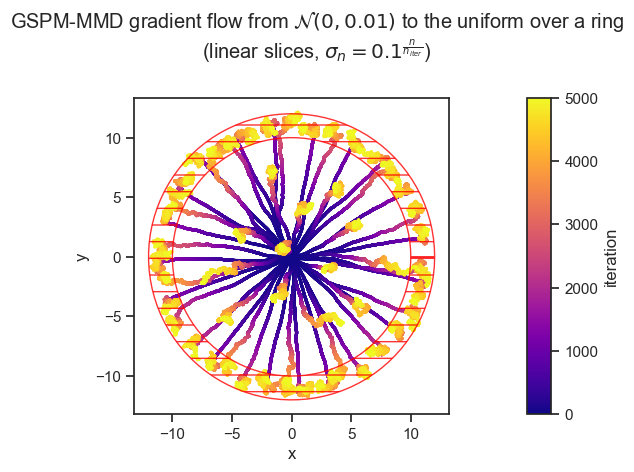

In [54]:
ax = plot_flow(X, title=r"GSPM-MMD gradient flow from $\mathcal{N}(0, 0.01)$ to the uniform over a ring"
               + "\n" + r"(linear slices, $\sigma_n = 0.1^{\frac{n}{n_{iter}}}$)")
t = np.linspace(0, 2*np.pi, 100)
xx = np.concatenate((R*np.cos(t), (R+dR)*np.cos(-t)))
yy = np.concatenate((R*np.sin(t), (R+dR)*np.sin(-t)))
ax.fill(xx, yy, color='none', ec='red', hatch='-', alpha=.8)
ax.set(aspect='equal')
plt.tight_layout()
plt.savefig("GSPM-MMD_flow_gauss_to_ring_annealing_exp.png")

In [24]:
# Gaussian to gaussian, simple slices
f = f_linear
df = df_linear
d = 2
N = 50
def target_sampler(M):
    return 5 + rng.standard_normal((M,d))
def initial_sampler(N):
    return rng.standard_normal((N, d)) - 5
M = 50
theta_sampler = theta_sampler_linear
K = 20
n_iter = 5000
eta = 1
beta = lambda n: .1/(n+1)**2
sigma = lambda n: 10 - int(n >= n_iter/4)*4/3*(n/n_iter - .25)*9.9
X = GSPM_MMD_gradient_flow_varying_radius(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma)

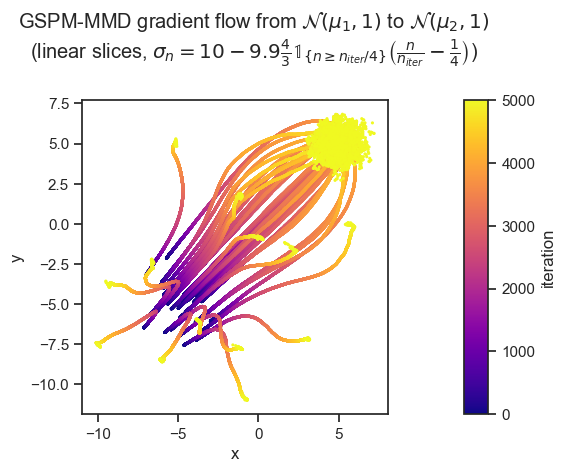

In [28]:
ax = plot_flow(X, title=r"GSPM-MMD gradient flow from $\mathcal{N}(\mu_1, 1)$ to $\mathcal{N}(\mu_2, 1)$"
               + "\n" + r"(linear slices, $\sigma_n = 10 - 9.9\frac{4}{3}\mathbb{1}_{\{n \geq n_{iter}/4\}}\left(\frac{n}{n_{iter}} - \frac{1}{4}\right)$)")
ax.set(aspect='equal')
plt.tight_layout()
plt.savefig("GSPM-MMD_flow_2gauss_annealing.png")

In [10]:
# gaussian to 2 gaussians, simple slices
f = f_linear
df = df_linear
d = 2
N = 50
means = np.array([[0, 0],
                  [0, 5]])
def target_sampler(M):
    k = rng.integers(0, 2, M)
    return means[k,:] + rng.standard_normal((M,d))
def initial_sampler(N):
    return means[0,:] + rng.standard_normal((N, d))
M = 50
theta_sampler = theta_sampler_linear
K = 50
n_iter = 5000
eta = .5
beta = lambda n: 1/np.sqrt(n+1)
sigma = lambda n: 10 - int(n >= n_iter/4)*4/3*(n/n_iter - .25)*9.9

In [ ]:
X = GSPM_MMD_gradient_flow_varying_radius(initial_sampler, N, target_sampler, M, theta_sampler, K, f, df, n_iter, eta, beta, sigma)

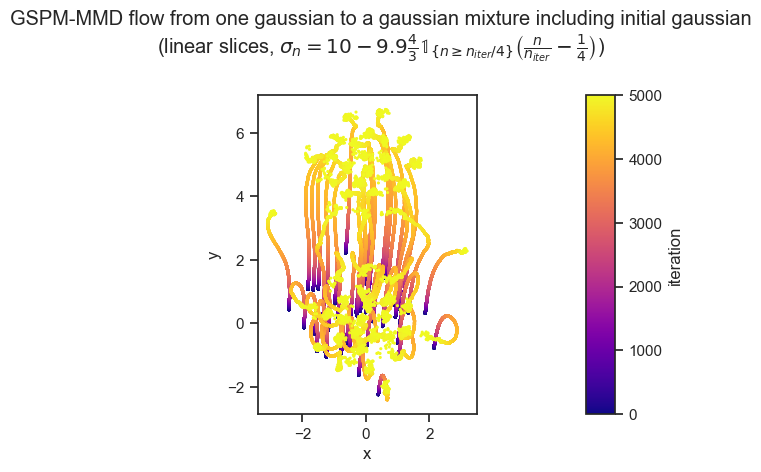

In [16]:
ax = plot_flow(X, title=r"GSPM-MMD flow from one gaussian to a gaussian mixture including initial gaussian"
               + "\n" + r"(linear slices, $\sigma_n = 10 - 9.9\frac{4}{3}\mathbb{1}_{\{n \geq n_{iter}/4\}}\left(\frac{n}{n_{iter}} - \frac{1}{4}\right)$)")
ax.set(aspect='equal')
plt.tight_layout()
plt.savefig("flow_multimodal_annealing.png", bbox_inches='tight')